In [1]:
''' RNN Bidireccional en Keras '''
__author_ = '@Tssp'
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Dropout
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
import pandas as pd  
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.dates as mdates
from utils.NNutils import *
plt.rcParams['xtick.labelsize']=13
plt.rcParams['ytick.labelsize']=13
plt.rcParams['axes.labelsize']=16
plt.rcParams['axes.titlesize']=16

Using TensorFlow backend.


In [46]:
# Radon
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
#newValuesReal = np.loadtxt('../../mdnRnA_validation2.txt', delimiter=',')[:-14]
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
dates[-1]
len(newValuesReal)

9

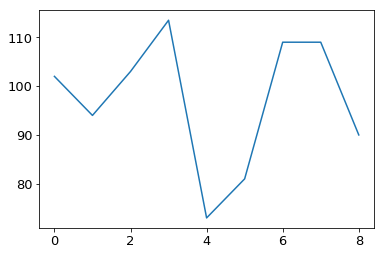

In [47]:
plt.plot(newValuesReal)

In [48]:
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
NVR.describe()

,tmed,velmedia,presmed
count,316.000000,316.000000,316.000000
mean,13.614248,3.577390,965.829927
std,6.472158,1.177355,5.245625
min,1.271429,0.528571,947.739409
25%,7.857143,2.782143,963.025000
50%,13.657143,3.542857,965.839286
75%,18.934184,4.378571,968.598214
max,26.957143,6.585714,980.928571


In [49]:
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': NVR['tmed'].values})
DF.head()

,T,dates,mdnRnA
0,21.800000,2013-07-07,90.0
1,25.271429,2013-07-14,79.0
2,24.614286,2013-07-21,99.0
3,25.842857,2013-07-28,117.0
4,25.314286,2013-08-04,99.0


In [50]:
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
#print('pdata_raw 0',pdata_raw)
print('pdata 0',pdata)

pdata 0 Empty DataFrame
Columns: []
Index: []


In [51]:
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF[['T', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe

In [52]:
pdatamdnRnA.head(7)

,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA,mdnRnA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.0,79.0
2,NaN,NaN,NaN,NaN,NaN,NaN,90.0,79.0,99.0
3,NaN,NaN,NaN,NaN,NaN,90.0,79.0,99.0,117.0
4,NaN,NaN,NaN,NaN,90.0,79.0,99.0,117.0,99.0
5,NaN,NaN,NaN,90.0,79.0,99.0,117.0,99.0,99.0
6,NaN,NaN,90.0,79.0,99.0,117.0,99.0,99.0,86.0


In [53]:
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])
pdatalags.shape

(308, 18)

In [54]:
X = np.array([pdatalags[start:start+sample_size] for start in range(0, pdatalags.shape[0]-sample_size)])
Y = pdatamdnRnAlags[sample_size:]
Y.shape

(256, 9)

In [55]:
test_size = int(0.3*len(mdnRnA))
X_train, X_test = X[:-test_size], X[-test_size:]
Y_train, Y_test = Y[:-test_size], Y[-test_size:]
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (162, 52, 18) 
Y_train.shape =  (162, 9)


In [56]:
def NN_v2(neurons, nep, X_train, Y_train, X_test, Y_test, sample_size, v=0, btch_size=10, save=False):
    model = Sequential()
    model.add(Conv1D(filters=int(neurons[0]), kernel_size=3, activation='relu', input_shape=X_train.shape[1:]))
    model.add(Conv1D(filters=int(neurons[1]), kernel_size=3, activation='relu'))
    model.add(Flatten())
    #model.add(Dropout(0.2))
    model.add(Dense(int(neurons[0]/2), activation='relu'))
    model.add(Dense(int(neurons[1]/2), activation='relu'))
    model.add(Dense(Y_train.shape[1], activation='linear'))
    model.compile(loss="mae", optimizer="adam", metrics=["acc"])
    history = model.fit(X_train, Y_train, epochs=nep, batch_size=btch_size, verbose=v, validation_data=(X_test, Y_test))
    pred = model.predict(X_test)
    acc_train = np.average(history.history["acc"])
    acc_test = np.average(history.history["val_acc"])
    if save:
        save_NN(model)
    return history, pred, acc_train, acc_test, model

In [67]:
neuron = [128, 256]
history, pred, acc_train, acc_test, model = NN_v2(neuron, 80, X_train, Y_train, X_test, Y_test, sample_size)

In [68]:
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)

ECM: 51.4130
EAM: 4.9099
4.516156577049418


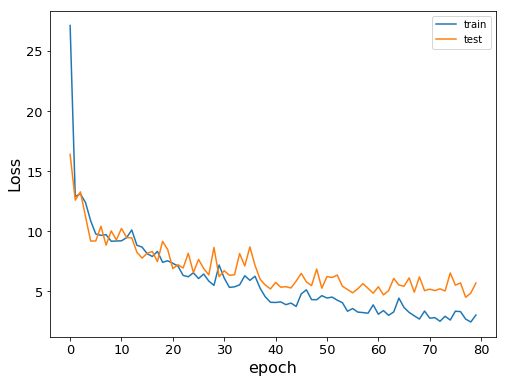

In [69]:
Y_test_error = DF['mdnRnA'][-len(predavgs):]
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [70]:
startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D') - 7*pd.Timedelta(len(newValuesReal),
                                                                                                           unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')

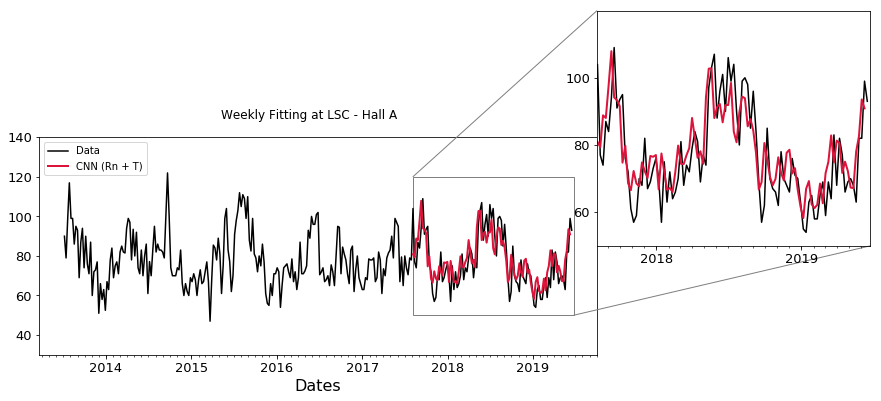

In [71]:
plot_forecast(mdnRnA, startday, predavgs, startdaypred)

In [72]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatalags[-sample_size:]]))
predval = model.predict(Xval)[0,:]

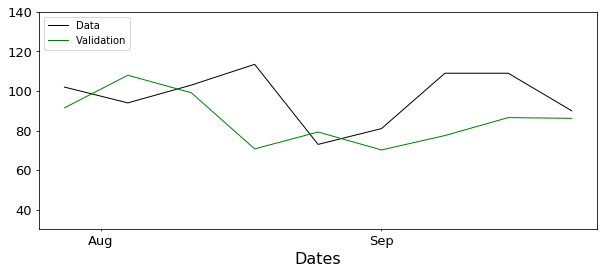

In [73]:
plot_validation(newValuesReal, predval, startdayahead)

In [74]:
# np.savetxt('CNN_Loss_RnT_PMP_{}_{}_v2.txt'.format(neuron[0], neuron[1]), (history.history['loss'], history.history['val_loss']), delimiter=',')
# np.savetxt('CNN_RnT_PMP_{}_{}_v2.txt'.format(neuron[0], neuron[1]), (predmins, predmaxs, predavgs), delimiter=',', fmt='%s')
# np.savetxt('CNN_validation_{}_{}_v2.txt'.format(neuron[0], neuron[1]), (newValuesReal, predval, startdayahead), delimiter=',', fmt='%s')

In [75]:
dist = mdnRnA[-len(predavgs):] - predavgs

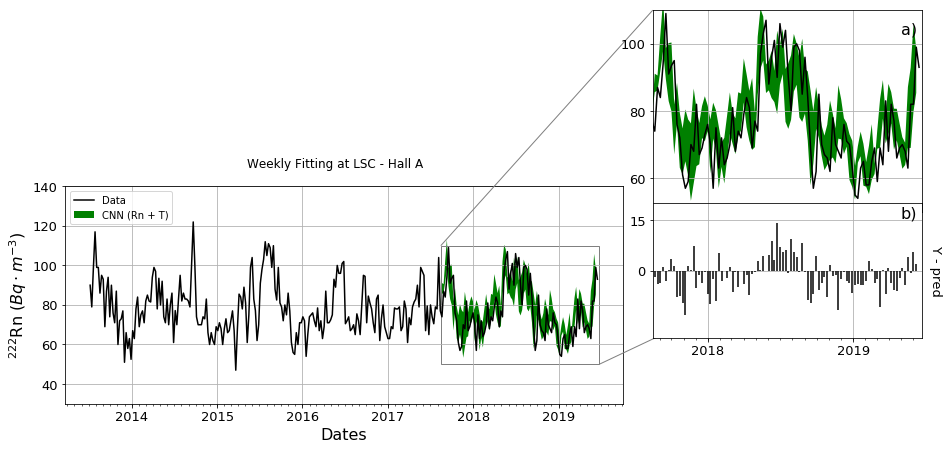

In [76]:
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)

# Only $^{222}Rn$

In [77]:
mdnRnA = np.loadtxt('../../mdnRnA.txt', delimiter=',')
newValuesReal = np.loadtxt('../../mdnRnA_validation.txt', delimiter=',')
nlags= len(newValuesReal)-1
startday = pd.datetime(2013, 7, 1)
dates = pd.date_range(startday, periods=len(mdnRnA), freq='W')
# Weather
NVR = pd.read_csv('../Data/Daily/NVR/NVR_arima_weekly.csv', usecols=['fecha', 'tmed', 'presmed', 'velmedia'])
NVR['fecha'] = pd.to_datetime(NVR['fecha'])
DF = pd.DataFrame({'dates': dates,'mdnRnA': mdnRnA, 'T': NVR['tmed'].values})
sample_size = 52
# dataframe (empty) creation
pdata = pd.DataFrame()
pdatamdnRnA = pd.DataFrame()
names=list()
nlags= len(newValuesReal)-1
for i in range(nlags, -1, -1):
    # Add the new lagged column at the end of the dataframe. In inverse order.
    pdata = pd.concat([pdata, DF[['T', 'mdnRnA']].shift(i).reset_index(drop=True)], axis=1)
    pdatamdnRnA = pd.concat([pdatamdnRnA, DF['mdnRnA'].shift(i).reset_index(drop=True)], axis=1)
    names += str(i) # store this index for naming the columns of dataframe
pdatalags = np.asarray(pdata[nlags:])
pdatamdnRnAlags = np.asarray(pdatamdnRnA[nlags:])   
X = np.atleast_3d(np.array([pdatamdnRnAlags[start:start + sample_size]
    for start in range(0, pdatamdnRnAlags.shape[0]-sample_size)]))
Y = pdatamdnRnAlags[sample_size:]
test_size = int(0.3*len(mdnRnA))
X_train,X_test = X[:-test_size], X[-test_size:]
Y_train,Y_test = Y[:-test_size], Y[-test_size:]

In [78]:
print("X_train.shape = ", X_train.shape, "\nY_train.shape = ", Y_train.shape)

X_train.shape =  (162, 52, 9) 
Y_train.shape =  (162, 9)


In [79]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 50, 128)           7040      
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 48, 256)           98560     
_________________________________________________________________
flatten_7 (Flatten)          (None, 12288)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                786496    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_21 (Dense)             (None, 9)                 1161      
Total params: 901,577
Trainable params: 901,577
Non-trainable params: 0
_________________________________________________________________


In [80]:
neuron = [64, 128]
history, pred, acc_train, acc_test, model = NN_v2(neuron, 80, X_train, Y_train, X_test, Y_test, sample_size)
predmaxs, predmins, predavgs = extract_maxs_mins_avgs(pred)

ECM: 41.1226
EAM: 4.5556
4.7460620352562435


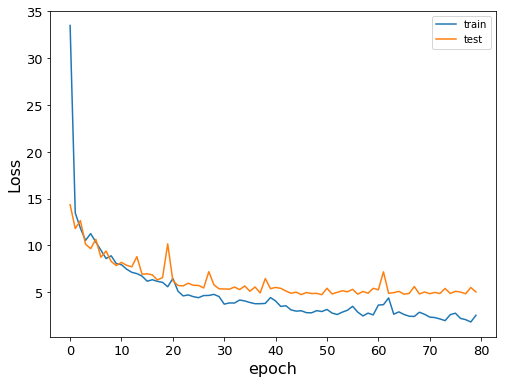

In [81]:
Y_test_error = DF['mdnRnA'][-len(predavgs):]
testScoreECM = mean_squared_error(Y_test_error, predavgs)
print('ECM: %.4f' % (testScoreECM))
testScoreEAM = mean_absolute_error(Y_test_error, predavgs)
print('EAM: %.4f' % (testScoreEAM))
fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))# 6,6
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
print(np.min(history.history['val_loss']))

In [82]:
# Pronostico:
Xval = np.atleast_3d(np.array([pdatamdnRnAlags[-sample_size:]]))
predval = model.predict(Xval)[0,:]

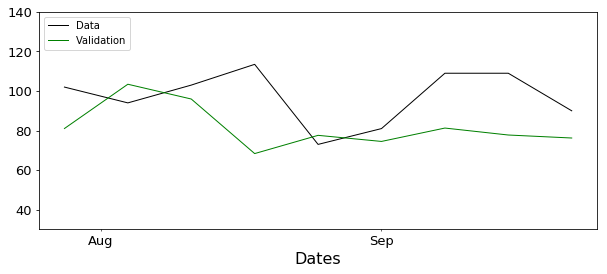

In [83]:
plot_validation(newValuesReal, predval, startdayahead)

In [84]:
startday = pd.datetime(2013, 7, 1)
startdaypred = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA)-len(pred), unit='D') - 7*pd.Timedelta(len(newValuesReal),
                                                                                                           unit='D')
startdayahead = pd.datetime(2013, 7, 1) + 7*pd.Timedelta( len(mdnRnA), unit='D')

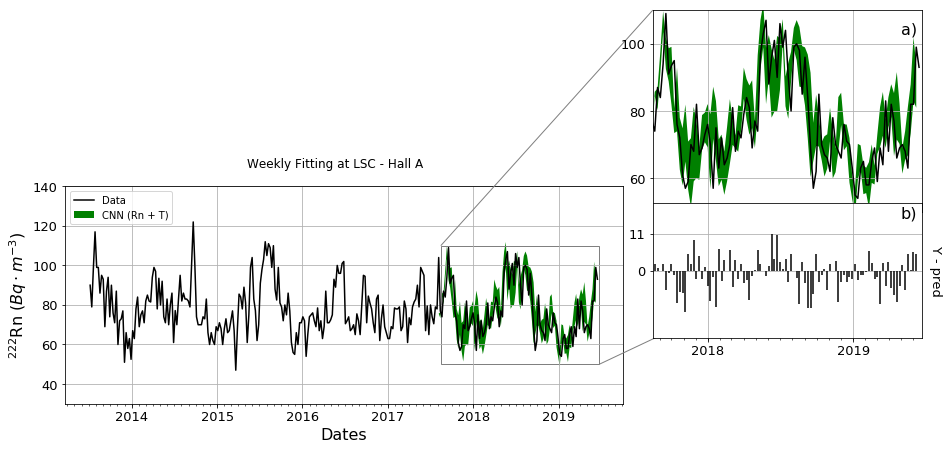

In [85]:
dist = DF[DF['dates'] > '2017-08-06']['mdnRnA'] - predavgs
plot_fill_errors(mdnRnA, predmins, predmaxs, predavgs, dist, startday, startdaypred)